# imports

In [17]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import cv2
# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import config_gpu
print("Número de GPUs disponíveis: ", len(
    tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[config_gpu.INDEX_GPU], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[config_gpu.INDEX_GPU], True)
    except RuntimeError as e:
        print(e)

Número de GPUs disponíveis:  2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# model n grad-cam

In [3]:
df_bb = pd.read_csv("./dataset/BBox_List_2017.csv")

In [4]:
df = pd.read_csv("df_ori_mask_crop.csv")

In [5]:
df_bb

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,NaN,NaN,NaN
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN


In [ ]:
# model_builder = keras.applications.xception.Xception
model_builder = keras.models.load_model("/home/lucas_araujo/pibic-2024/classificacao_multilabel_chest/records/model_v5_44fef67f/model_0.808")

Image exists in DataFrame
./dataset/CXR8/images/images_008/images/00016990_000.png
Cardiomegaly
312 475 458 301


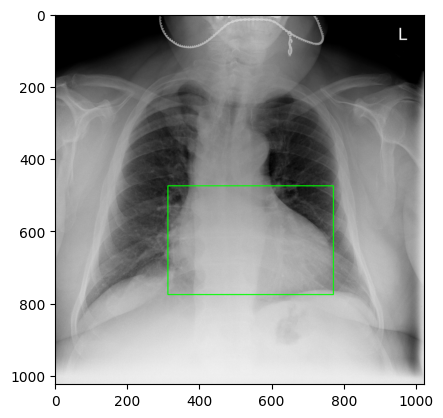

In [59]:
img = '00016990_000.png' 

if img in df['Image Index'].values:
  print('Image exists in DataFrame')
  row = df[df['Image Index'] == img]
  path = row['path'].values[0]
  label = row['Finding Labels'].values[0]
  image = cv2.imread(path)
  print(path)
  print(label)
  #x,y,w,h
  row_bb = df_bb[df_bb["Image Index"]== img]
  x = int(row_bb['Bbox [x'].values[0])
  y = int(row_bb['y'].values[0])
  w = int(row_bb['w'].values[0])
  h = int(row_bb['h]'].values[0])
  print(x,y,w,h)
  image_with_box = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
else:
  print('Image does not exist in DataFrame')
plt.imshow(image)

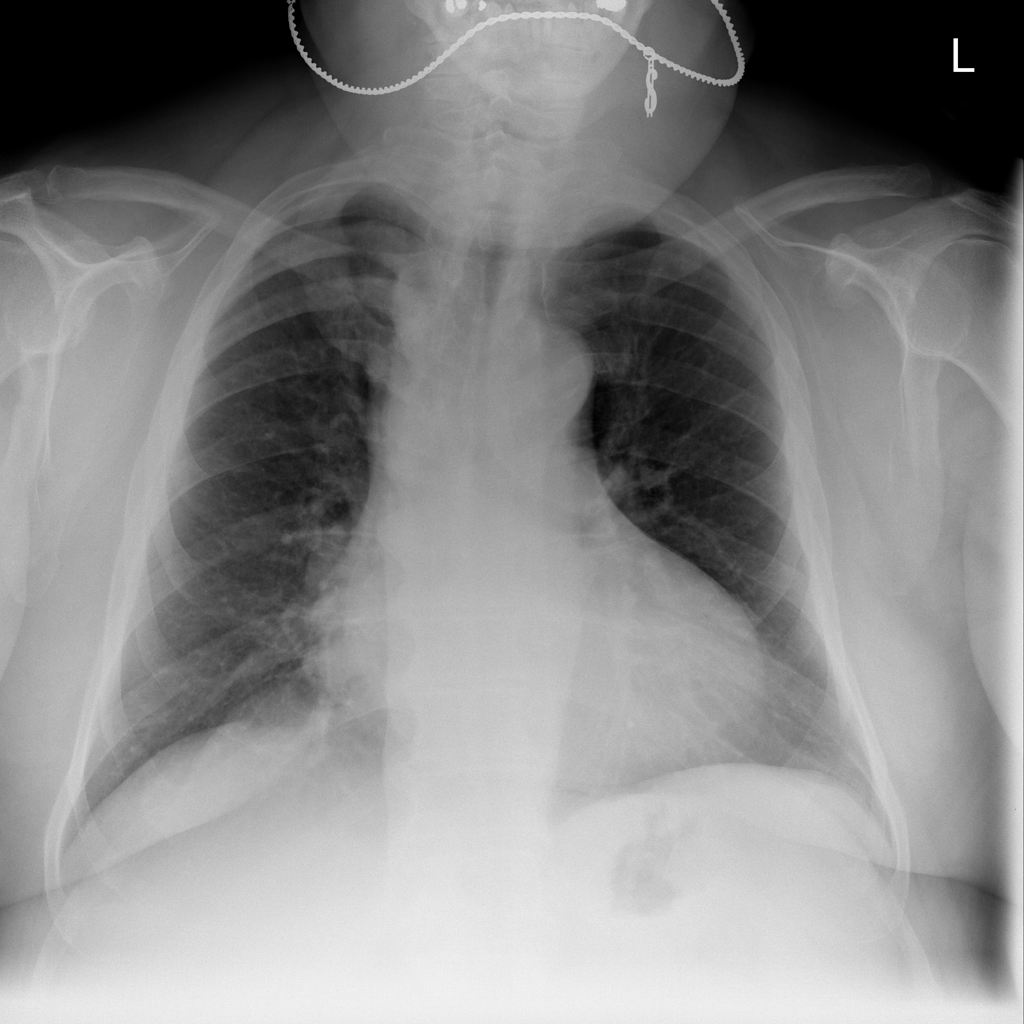

In [142]:
img_size = (256, 256)
# preprocess_input = keras.applications.xception.preprocess_input
# decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv5_block16_concat_2"

# The local path to our target image
img_path = "{}".format(path)

display(Image(img_path))

In [102]:
#teste do lote de treino
import data
val_generator_global = data.get_generator(
    df=pd.read_csv("/home/lucas_araujo/pibic-2024/classificacao_multilabel_chest/records/model_v5_a41cb713/df_val.csv"), x_col="path", shuffle=False)

Found 5116 validated image filenames.


In [104]:
z = next(val_generator_global)

In [ ]:
val_generator_global.filenames

In [112]:
np.max(z[0][0]), np.min(z[0][0])

(1.8666521, -1.9007527)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


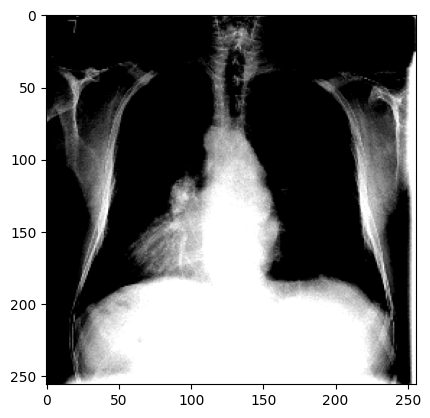

In [116]:
plt.imshow(z[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


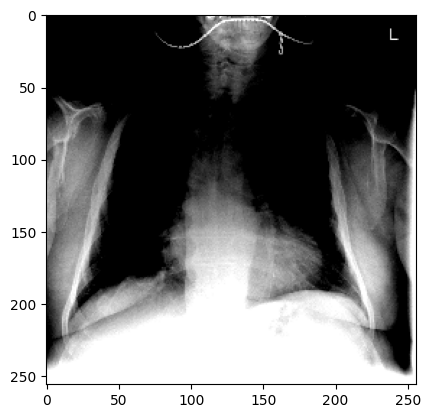

In [143]:
image = cv2.imread(path)
image = cv2.resize(image, (256,256))
# Normalizar a imagem
image_float = image.astype('float32')
datagen = keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
)

# Converter a imagem para array e normalizá-la
img_array = np.expand_dims(image_float, axis=0)

normalized_img = datagen.standardize(img_array)
plt.imshow(normalized_img[0])

In [139]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)

    #l 
    # image_float = image.astype('float32')
    datagen = keras.preprocessing.image.ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True,
    )

    #k
    array = np.expand_dims(array, axis=0)
    #l
    normalized_img = datagen.standardize(array)
    
    return normalized_img



def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 83ms/step


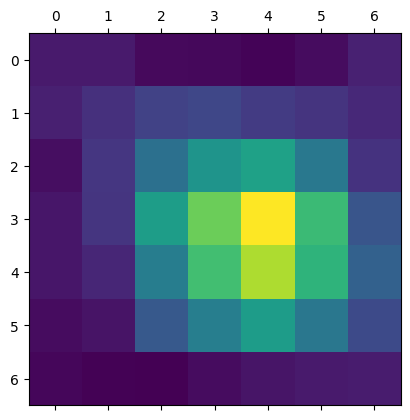

In [140]:
# Prepare image
# img_array = preprocess_input(get_img_array(img_path, size=img_size))
img_array = get_img_array(img_path, size=img_size)

# Make model
# model = model_builder(weights="imagenet")

# Remove last layer's softmax
model_builder.layers[-1].activation = None

# Print what the top predicted class is
preds = model_builder.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model_builder, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

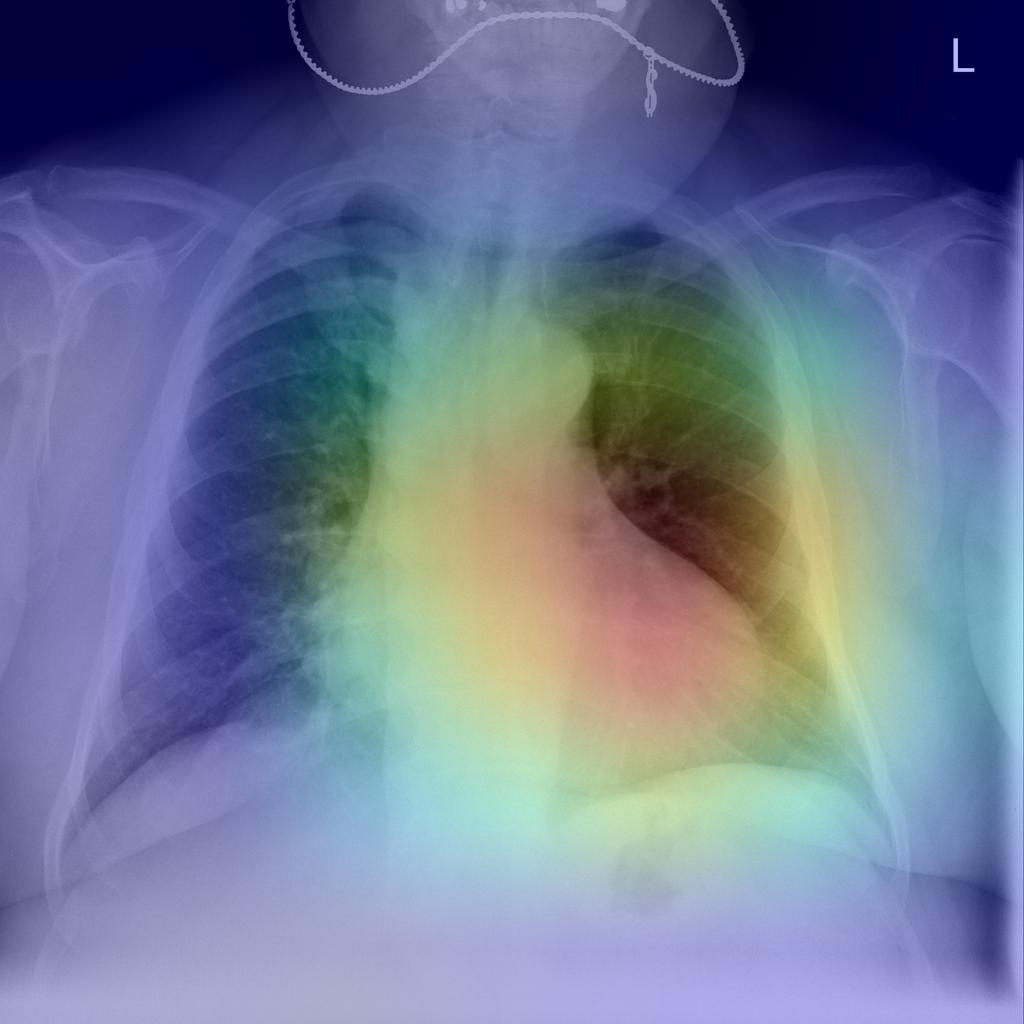

In [141]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)